In [1]:
import torch
from torch import nn, optim
import mltools

In [ ]:
train_iter, val_iter, test_iter, vocab = mltools.chn_senti_corp('../data/ChnSentiCorp_htl_all.csv')


class TransformerCSCModel(nn.Module):
    '''Transformer 分类模型'''

    def __init__(self, *args, **kwargs):
        '''初始化函数'''
        nn.Module.__init__(self, *args, **kwargs)
        self.embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=256, padding_idx=1)  # 定义嵌入层
        encode_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, batch_first=True)
        self.hidden_layer = nn.TransformerEncoder(encode_layer, num_layers=6)  # 定义隐藏层
        self.output_layer = nn.Linear(256, 2)  # 定义输出层

    def forward(self, x):
        '''前向传播'''
        x = self.embedding(x)  # 将输入嵌入, x形状为(批量大小, 时间步数, 嵌入大小)
        x = self.hidden_layer(x)  # x形状为(批量大小, 时间步数, 隐藏大小)
        x = self.output_layer(x[:, 0, :])  # 它的输出形状是(批量大小, 输出大小)
        return x
    

model = TransformerCSCModel()
device = torch.device('cuda')


class TransformerCSC(mltools.MachineLearning):
    '''Transformer 文本分类学习'''

    def train(self, num_epochs):
        '''迭代训练'''
        mltools.MachineLearning.train(self, num_epochs)
        for _ in range(1, num_epochs + 1):
            self.timer.start()

            # 计算训练集
            metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
            self.model.train()  # 训练模式
            for x, y in self.train_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_train = self.model(x)  # 计算模型
                train_loss = self.loss(y_train, y)  # 计算训练损失

                # 梯度更新
                self.optimizer.zero_grad()
                train_loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
                self.optimizer.step()

                metric_train.add(train_loss * len(y), len(y))
            self.recorder[0].append(metric_train[0] / metric_train[1])

            self.timer.stop()

            # 计算验证集
            metric_val = mltools.Accumulator(3)  # 累加器：(val_loss, val_acc, val_size)
            self.model.eval()  # 验证模式
            with torch.no_grad():
                for x, y in self.val_iter:
                    x = x.to(self.device)  # 转换x
                    y = y.to(self.device)  # 转换y
                    y_val = self.model(x)  # 计算模型
                    val_loss = self.loss(y_val, y)  # 计算验证损失
                    val_pred = y_val.argmax(dim=1)  # 计算预测值
                    val_acc = (val_pred == y).sum()  # 计算验证准确率
                    metric_val.add(val_loss * len(y), val_acc, len(y))
            self.recorder[1].append(metric_val[0] / metric_val[2])
            self.recorder[2].append(metric_val[1] / metric_val[2])

            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')
            self.animator.show(self.recorder.data, legend=['train loss', 'val loss', 'val acc'])  # 添加损失值
        else:
            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')

    def test(self):
        '''测试模型'''
        mltools.MachineLearning.test(self)
        metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
        with torch.no_grad():
            for x, y in self.test_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_test = self.model(x)  # 计算模型
                test_pred = y_test.argmax(dim=1)  # 计算准确率
                test_acc = (test_pred == y).sum()  # 计算测试准确率
                metric.add(test_acc, len(y))
        self.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

    def predict(self):
        '''预测模型'''
        mltools.MachineLearning.predict(self)
        x, y = next(iter(self.test_iter))  # 从测试中取一个批量
        x = x[:10].to(self.device)
        y = y[:10].to(self.device)
        y_pred = self.model(x)  # 计算模型
        y_pred = y_pred.argmax(dim=1)  # 计算预测
        for content, pred, real in zip(x, y_pred, y):
            print(f'预测值 {pred}, 真实值 {real}, 数据 {''.join(vocab[content.tolist()]).replace('<pad>', ' ')}')


ml = TransformerCSC(model, train_iter, val_iter, test_iter, device=device)

2025-05-22 22:23:35,159 - INFO: train loss 2.144, val loss 2.354, val acc 0.674, 49.1 sec/epoch on cuda


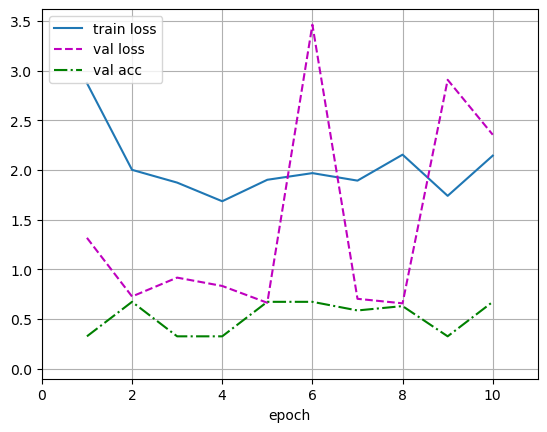

In [ ]:
ml.set_loss(nn.CrossEntropyLoss())
ml.set_optimizer(optim.SGD(model.parameters(), lr=1))
ml.train(num_epochs=10)  # 训练
ml.save()  # 保存模型

In [4]:
ml.test()  # 测试

2025-05-22 22:23:38,582 - INFO: test acc 0.684


In [5]:
ml.predict()  # 预测

pred: 1, real: 0, text: 我订的是普通标准间B,感觉非常的糟糕.尤其是淋浴房没设计好,洗完澡之后水流的一地都是,第二天都没干,严重影响心情,本来计划住二天,无奈第二天早上退房了.                                                                                                                            
pred: 1, real: 1, text: 已经住过几次这家酒店，感觉非常好。服务员态度友善，又够专业，客房的装设时尚、舒适，配套设施齐全，使用起来很方便。总之，来郑州，住索菲特是个很好的选择。                                                                                                                             
pred: 1, real: 1, text: 酒店外观不怎么样，但是里面的服务很好，而且房间超级大，床也超级大，绝对可以睡4个人，早餐也可以。总体来说不错，性价比还ok。从虹桥机场过去打车19块，十来分钟就到了。要是在虹桥附近办事，推荐这家酒店，很方便。                                                                                                
pred: 1, real: 1, text: 因这酒店不在市区,所以总体服务环境还可以,但二楼吃饭的餐厅有点贵了.                                                                                                                                                                      
pred: 1, real: 1, text: 回来2天了，很忙，没来得及评价，今天周末得闲谈谈入住海景酒店的感触。我是7.25---7.30入住海景的，因为是家里人度假，加之孩子比较小（5岁），所以